In [1]:
## Import

random_state = 1232454

from stanscofi.utils import load_dataset
from stanscofi.datasets import Dataset
from stanscofi.training_testing import traintest_validation_split, print_folds, cv_training
from stanscofi.validation import compute_metrics, plot_metrics

from glob import glob
from time import time

import sys
sys.path.insert(0,"src/")

/home/kali/miniconda3/envs/stanscofi_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-27 14:31:23.128604: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 14:31:23.894454: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
## Parameters

dataset_names = ["Gottlieb"]
dataset_name = dataset_names[0]

model_names=["LRSSL"]
model_name = model_names[0]

In [3]:
## Dataset

dataset_di = load_dataset(dataset_name, "datasets/")
dataset_di.setdefault("same_item_user_features", dataset_name=="TRANSCRIPT")
dataset_di.setdefault("name", dataset_name)
dataset = Dataset(**dataset_di)
#dataset.summary()

metric = "cosine" 
test_size = 0.2

train_folds, test_folds, _,_ = traintest_validation_split(dataset, test_size=test_size, 
    early_stop=2, metric=metric, disjoint_users=False, verbose=False, random_state=random_state, print_dists=True)

## Prints the contents of the folds
#for sett in ["train_folds", "test_folds"]:
#    print_folds(eval(sett), dataset, sett)

train_dataset = dataset.get_folds(train_folds, dataset.name+"-train")

test_dataset = dataset.get_folds(test_folds, dataset.name+"-test")

<training_testing.traintest_validation_split> The sets of items/drugs in the training/testing datasets are disjoint.
<training_testing.traintest_validation_split> The sets of users/diseases in the training/testing datasets are *not* disjoint.
<training_testing.traintest_validation_split> Distances:
              Train set  Test set
Train set  1.110223e-16  0.010329
Test set   1.032949e-02  0.000072


In [52]:
from importlib import reload

import benchscofi
import benchscofi.LRSSL
reload(benchscofi.LRSSL)

model = benchscofi.LRSSL.LRSSL(benchscofi.LRSSL.LRSSL().default_parameters())
#model.fit(train_dataset)
model.fit(dataset)

[(593, 593), (593, 593)]
[(593, 593), (593, 593)]


NameError: name 'r' is not defined

In [4]:
## Model

import benchscofi
__import__("benchscofi."+model_name)

#from importlib import reload
#reload(benchscofi)
#reload(benchscofi.SimplePULearning)

njobs, nsplits=4, 5

start=time() 
params = {"decision_threshold": 0.5, "preprocessing_str": "meanimputation_standardize", 
          "PI": (train_dataset.ratings_mat>0).mean().mean(), "layers_dims": [16,32], "subset": None,
         "steps_per_epoch": 1, "epochs": 50}

print("PI = %.2f" % params["PI"])

best_estimator = cv_training(eval("benchscofi."+model_name+"."+model_name), params, train_dataset, 
    metric="AUC", njobs=njobs, random_state=random_state, nsplits=nsplits, show_plots=False, verbose=False) 

print("Elapsed time: %.2f sec. (njobs=%d)" % (time()-start, njobs))

"AUC on Test %f (Train %f)" % (best_estimator["test_AUC"], best_estimator["train_AUC"])

PI = 0.01


5it [00:00, 53.47it/s]


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

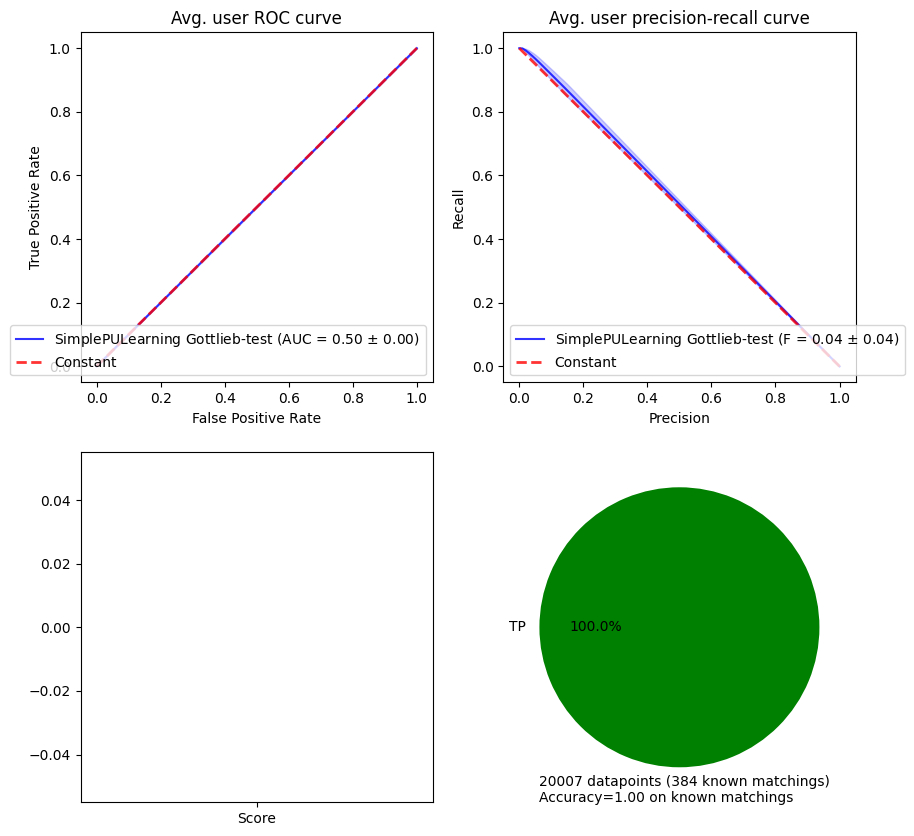

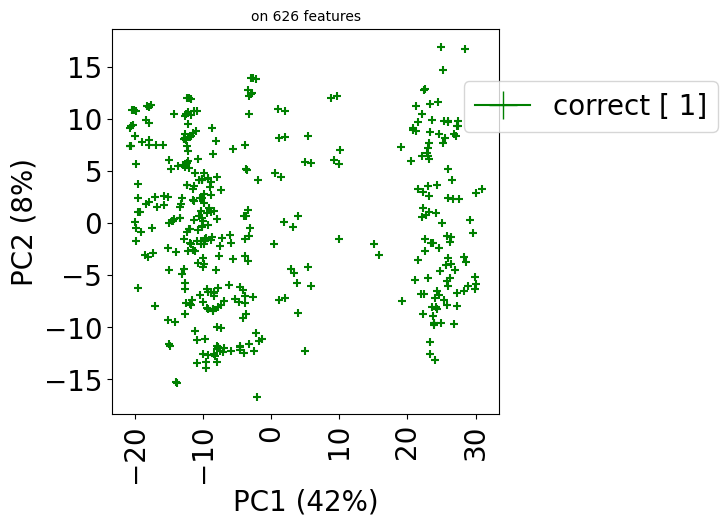

,Avg. across users,Std
AUC,0.500000,0.000000
F_1.0,0.036896,0.037479


In [7]:
## Validation

model = eval("benchscofi."+model_name+"."+model_name)(params)
model.fit(train_dataset.get_folds(best_estimator["cv_folds"][0]))
#val_dataset = train_dataset.get_folds(best_estimator["cv_folds"][1], "val")

scores = model.predict(test_dataset)
#model.print_scores(scores)
predictions = model.classify(scores)
#model.print_classification(predictions)
metrics, plot_args = compute_metrics(scores, predictions, test_dataset, beta=1,verbose=True)
plot_metrics(**plot_args, figsize=(10,10), model_name=model.name+" "+test_dataset.name)
test_dataset.visualize(predictions=predictions, show_errors=True)

metrics